In [5]:
import torch

from rl4co.envs import TSPEnv, PDPEnv, RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AttentionModelPolicy
from rl4co.utils.trainer import RL4COTrainer

from typing import Optional
import torch
import torch.nn as nn

from tensordict.tensordict import TensorDict
from torchrl.data import (
    BoundedTensorSpec,
    CompositeSpec,
    UnboundedContinuousTensorSpec,
    UnboundedDiscreteTensorSpec,
)

from rl4co.envs.common.base import RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy
from rl4co.utils.ops import gather_by_index, get_tour_length
from rl4co.utils.trainer import RL4COTrainer

tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([True, True])
tensor([-10.3022, -10.2247])


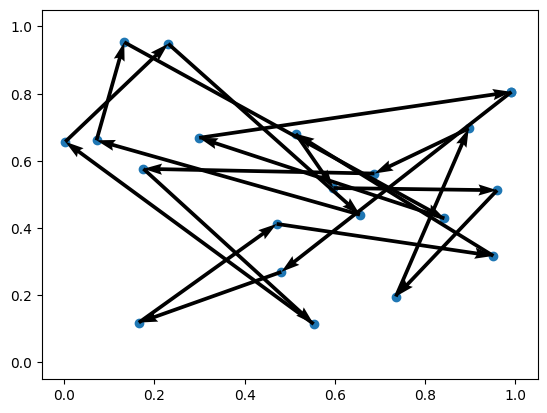

In [3]:
def _reset(self, td: Optional[TensorDict] = None, batch_size=None) -> TensorDict:
    # Initialize locations
    init_locs = td["locs"] if td is not None else None
    if batch_size is None:
        batch_size = self.batch_size if init_locs is None else init_locs.shape[:-2]
    device = init_locs.device if init_locs is not None else self.device
    self.to(device)
    if init_locs is None:
        init_locs = self.generate_data(batch_size=batch_size).to(device)["locs"]
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size

    # We do not enforce loading from self for flexibility
    num_loc = init_locs.shape[-2]

    # Other variables
    current_node = torch.zeros((batch_size), dtype=torch.int64, device=device)
    available = torch.ones(
        (*batch_size, num_loc), dtype=torch.bool, device=device
    )  # 1 means not visited, i.e. action is allowed
    i = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)

    return TensorDict(
        {
            "locs": init_locs,
            "first_node": current_node,
            "current_node": current_node,
            "i": i,
            "action_mask": available,
            "reward": torch.zeros((*batch_size, 1), dtype=torch.float32),
        },
        batch_size=batch_size,
    )

def _step(self, td: TensorDict) -> TensorDict:
    current_node = td["action"]
    first_node = current_node if td["i"].all() == 0 else td["first_node"]

    # Set not visited to 0 (i.e., we visited the node)
    # Note: we may also use a separate function for obtaining the mask for more flexibility
    available = td["action_mask"].scatter(
        -1, current_node.unsqueeze(-1).expand_as(td["action_mask"]), 0
    )

    # We are done there are no unvisited locations
    done = torch.sum(available, dim=-1) == 0
    print(done)

    # The reward is calculated outside via get_reward for efficiency, so we set it to 0 here
    reward = torch.zeros_like(done)

    td.update(
        {
            "first_node": first_node,
            "current_node": current_node,
            "i": td["i"] + 1,
            "action_mask": available,
            "reward": reward,
            "done": done,
        },
    )
    return td

def get_action_mask(self, td: TensorDict) -> TensorDict:
    # Here: your logic 
    return td["action_mask"]

def check_solution_validity(self, td: TensorDict, actions: torch.Tensor):
    """Check that solution is valid: nodes are visited exactly once"""
    assert (
        torch.arange(actions.size(1), out=actions.data.new())
        .view(1, -1)
        .expand_as(actions)
        == actions.data.sort(1)[0]
    ).all(), "Invalid tour"

def get_reward(self, td, actions) -> TensorDict:
    # Sanity check if enabled
    if self.check_solution:
        self.check_solution_validity(td, actions)

    # Gather locations in order of tour and return distance between them (i.e., -reward)
    locs_ordered = gather_by_index(td["locs"], actions)
    return -get_tour_length(locs_ordered)


def _make_spec(self, td_params):
    """Make the observation and action specs from the parameters"""
    self.observation_spec = CompositeSpec(
        locs=BoundedTensorSpec(
            low=self.min_loc,
            high=self.max_loc,
            shape=(self.num_loc, 2),
            dtype=torch.float32,
        ),
        first_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            shape=(self.num_loc),
            dtype=torch.bool,
        ),
        shape=(),
    )
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        low=0,
        high=self.num_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))
    self.done_spec = UnboundedDiscreteTensorSpec(shape=(1,), dtype=torch.bool)

def generate_data(self, batch_size) -> TensorDict:
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size
    locs = (
        torch.rand((*batch_size, self.num_loc, 2), generator=self.rng)
        * (self.max_loc - self.min_loc)
        + self.min_loc
    )
    return TensorDict({"locs": locs}, batch_size=batch_size)

def render(self, td, actions=None, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        # Create a plot of the nodes
        _, ax = plt.subplots()

    td = td.detach().cpu()

    if actions is None:
        actions = td.get("action", None)
    # if batch_size greater than 0 , we need to select the first batch element
    if td.batch_size != torch.Size([]):
        td = td[0]
        actions = actions[0]

    locs = td["locs"]

    # gather locs in order of action if available
    if actions is None:
        print("No action in TensorDict, rendering unsorted locs")
    else:
        actions = actions.detach().cpu()
        locs = gather_by_index(locs, actions, dim=0)

    # Cat the first node to the end to complete the tour
    locs = torch.cat((locs, locs[0:1]))
    x, y = locs[:, 0], locs[:, 1]

    # Plot the visited nodes
    ax.scatter(x, y, color="tab:blue")

    # Add arrows between visited nodes as a quiver plot
    dx, dy = np.diff(x), np.diff(y)
    ax.quiver(
        x[:-1], y[:-1], dx, dy, scale_units="xy", angles="xy", scale=1, color="k"
    )

    # Setup limits and show
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

class TSPEnv(RL4COEnvBase):
    """Traveling Salesman Problem (TSP) environment"""

    name = "tsp"

    def __init__(
        self,
        num_loc: int = 20,
        min_loc: float = 0,
        max_loc: float = 1,
        td_params: TensorDict = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.num_loc = num_loc
        self.min_loc = min_loc
        self.max_loc = max_loc
        self._make_spec(td_params)
        
    _reset = _reset
    _step = _step
    get_reward = get_reward
    check_solution_validity = check_solution_validity
    get_action_mask = get_action_mask
    _make_spec = _make_spec
    generate_data = generate_data
    render = render

def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td


def rollout(env, td, policy, max_steps: int = None):
    """Helper function to rollout a policy. Currently, TorchRL does not allow to step
    over envs when done with `env.rollout()`. We need this because for environments that complete at different steps.
    """

    max_steps = float("inf") if max_steps is None else max_steps
    actions = []
    steps = 0

    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
        steps += 1
        if steps > max_steps:
            print("Max steps reached")
            break
    return (
        env.get_reward(td, torch.stack(actions, dim=1)),
        td,
        torch.stack(actions, dim=1),
    )

batch_size = 2

env = TSPEnv(num_loc=20)
reward, td, actions = rollout(env, env.reset(batch_size=[batch_size]), random_policy)
print(reward)
env.render(td, actions)

In [7]:
# Instantiate our environment
env = TSPEnv(num_loc=20)

policy = AttentionModelPolicy(env.name, 
                              embedding_dim=128, 
                              num_encoder_layers=3, 
                              num_heads=8,)


# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_000,
                       val_data_size=10_000)

/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: 9.560
Problem 2 | Cost: 13.025
Problem 3 | Cost: 11.158


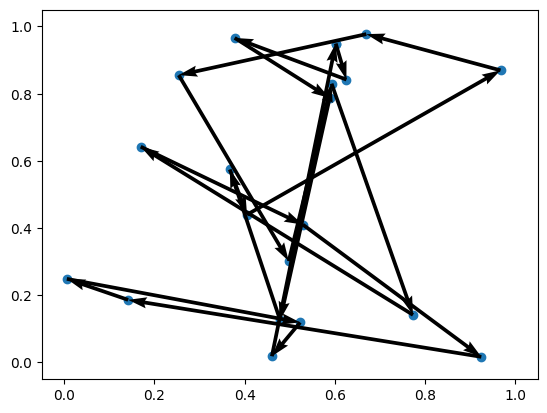

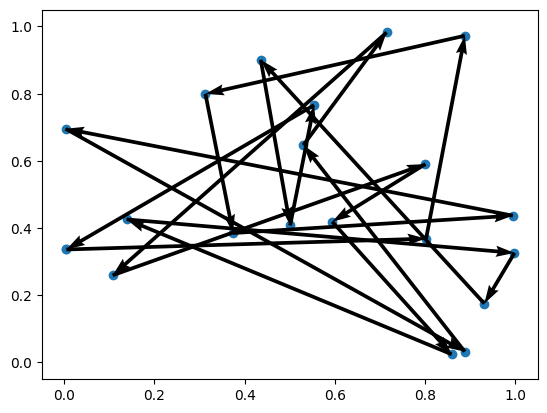

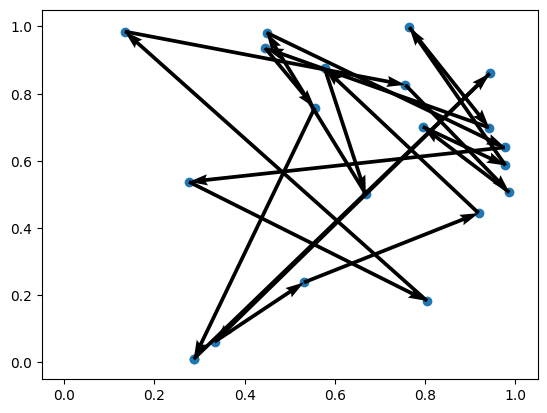

In [10]:
# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])